# **Imports**

In [2]:
import numpy as np
import pandas as pd
import time
import warnings 
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from pprint import pprint


# **Modelo KNN**

In [3]:
from pickle import NONE
class KNearestNeighbors(BaseEstimator, ClassifierMixin):
    def __init__(self, X_train, y_train, n_neighbors=5, weights='uniform'):

        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors
        self.weights = weights

        self.n_classes = 10
        self.prediction = NONE

    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    def kneighbors(self, X_test, return_distance=False):

        dist = []
        neigh_ind = []
        point_dist = []
        for x_test in X_test:
            point_dist += [ self.euclidian_distance(x_test, self.X_train) ]

        for row in point_dist:
            enum_neigh = enumerate(row)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]
            dist_list = [tup[1] for tup in sorted_neigh]

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind)

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):

        if self.weights == 'uniform':
            neighbors = self.kneighbors(X_test)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor]))
                for neighbor in neighbors
            ])
            return y_pred

        if self.weights == 'distance':
            distances, neighbors = self.kneighbors(X_test, return_distance=True)
            y_pred = np.array([
                np.argmax(np.bincount(self.y_train[neighbor], 1 / (distances[i] + 1e-6)))
                for i, neighbor in enumerate(neighbors)
            ])
            self.prediction = y_pred
            return y_pred


# **Modelo Árbol de Decisión**

In [95]:
# Definición de la función para calcular la entropía
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Definición de la función para dividir los datos
def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]
    return X_left, y_left, X_right, y_right

# Definición de la clase del nodo del árbol de decisión
class Node:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

    def fit(self, X, y):
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.value = unique_classes[np.argmax(class_counts)]
        if self.depth == self.max_depth or len(unique_classes) == 1: # Se pregunta las dos condiciones de paradas, sin divisiones y profundidad máxima
            return

        num_features = X.shape[1] # cantidad de Features
        best_info_gain = -1 # métrica
        
        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = split_data(X, y, feature_index, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                info_gain = entropy(y) - ((len(y_left) / len(y)) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right))

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    self.feature_index = feature_index
                    self.threshold = threshold

        if self.feature_index is not None:
            X_left, y_left, X_right, y_right = split_data(X, y, self.feature_index, self.threshold)
            self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
            self.left.fit(X_left, y_left)
            self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
            self.right.fit(X_right, y_right)

    def predict(self, X):
        if self.feature_index is None:
            return self.value
        if X[self.feature_index] <= self.threshold:
            return self.left.predict(X)
        else:
            return self.right.predict(X)

# **Modelo Regresión Logística**

In [86]:
class OurLogisticRegression (BaseEstimator, ClassifierMixin):
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
       

    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # weights initialization
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h-y)) / y.size
            #print(gradient.shape, self.w.shape, z.shape,h.shape)
            #gradient = (h - y) / y.size
            self.w -= self.lr * gradient

    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold
    
    def score(self, y_pred,y_test):
        return float(sum(y_pred == y_test)) / float(len(y_test))


# **Dataset WeatherAUS**

In [8]:
dataset_path = "weatherAUS.csv"
dataset = pd.read_csv(dataset_path)

#Eliminemos las filas que no tengan un RainTomorrow definido
dataset = dataset.dropna(subset=["RainTomorrow"])

# Eliminamos algunos features de texto que no representan mayor diferencia al realizar la aproximación y obteneos los datos y el target
X = dataset.drop(["RainTomorrow", "Date", "WindDir9am", "WindDir3pm", "WindGustDir"], axis=1)
y = dataset["RainTomorrow"].replace({'No': 0, 'Yes': 1})

#Reemplazamos RainToday por números y las ubicaciones por números, guardando la referencia en location_number
X["RainToday"] = X["RainToday"].replace({'No': 0.0, 'Yes': 1.0})
unique_classes = X["Location"].unique()
location_number = {cls: idx for idx, cls in enumerate(unique_classes)}
X["Location"] = X["Location"].replace(location_number)

#Normalicemos los datos
min_val = X.min(axis=0)
max_val = X.max(axis=0)
X = (X - min_val) / (max_val - min_val)

#De los features de Wind vamos a quitar los más relacionados, al revisar los datos se ve que el WindGustSpeed está relacionado
#a los otros dos features, por lo que lo removeremos.
windCov = X[["WindGustSpeed", "WindSpeed9am", "WindSpeed3pm"]].cov()
print(windCov)
X = X.drop("WindGustSpeed", axis=1)

#Vamos a analizar los feature humidity y ver cómo se relacionan, no vamos a eliminar ninguno pues el nivel de relación no es lo suficientemente alto
humidCov = X[["Humidity9am", "Humidity3pm"]].cov()
print(humidCov)

#Vamos a analizar los feature pressure y ver cómo se relacionan, note que son altamente relacionados, por lo que vamos a eliminar uno arbitrariamente
pressureCov = X[["Pressure9am", "Pressure3pm"]].cov()
print(pressureCov)
X = X.drop("Pressure9am", axis=1)

#Vamos a analizar los feature cloud y ver cómo se relacionan, no vamos a eliminar ninguno pues el nivel de relación no es lo suficientemente alto
cloudCov = X[["Cloud9am", "Cloud3pm"]].cov()
print(cloudCov)

#Vamos a analizar los feature temp y ver cómo se relacionan, note que son altamente relacionados, por lo que vamos a eliminar el de las 9am como se hizo con pressure
tempCov = X[["Temp9am", "Temp3pm"]].cov()
print(tempCov)
X = X.drop("Temp9am", axis=1)

#Vamos a analizar si hay otros features altamente relacionados
#Note que MaxTemp está altamente relacionada con Temp3pm por lo que eliminaremos Temp3pm
XCov = X.cov()
print(XCov)
X = X.drop("Temp3pm", axis=1)

print(len(X))

#Vamos a reemplazar los nan con valores medios para que Sklearn y nuestro modelo puedan aceptarlos
X = X.to_numpy()
y = y.to_numpy()
WAX_train, WAX_test, WAy_train, WAy_test = train_test_split(X, y, test_size=0.15, random_state=45)

mean_train = np.nanmean(WAX_train)
mean_test = np.nanmean(WAX_test)

WAX_train[np.isnan(WAX_train)] = mean_train
WAX_test[np.isnan(WAX_test)] = mean_test



               WindGustSpeed  WindSpeed9am  WindSpeed3pm
WindGustSpeed       0.011096      0.004298      0.007207
WindSpeed9am        0.004298      0.004680      0.003580
WindSpeed3pm        0.007207      0.003580      0.010239
             Humidity9am  Humidity3pm
Humidity9am     0.036295     0.026446
Humidity3pm     0.026446     0.043255
             Pressure9am  Pressure3pm
Pressure9am     0.013794     0.012713
Pressure3pm     0.012713     0.012676
          Cloud9am  Cloud3pm
Cloud9am  0.102899  0.058228
Cloud3pm  0.058228  0.091381
          Temp9am   Temp3pm
Temp9am  0.018763  0.015611
Temp3pm  0.015611  0.017731
              Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
Location      0.084666  0.003147  0.004116 -0.000117     0.000479  0.005102   
MinTemp       0.003147  0.022807  0.014954  0.000358     0.002038  0.002825   
MaxTemp       0.004116  0.014954  0.018103 -0.000229     0.002272  0.016076   
Rainfall     -0.000117  0.000358 -0.000229  0.000521    -

# **Dataset Notas del Curso**

In [88]:
df1 = pd.read_table("DataSetNotas/notas1.csv", delimiter =",")
df1 = df1[['Examen 1 25.0%', 'Examen 2 25.0%', 'Quiz1', 'Total: ']]
df1.columns = ['E1', 'E2', 'Q1', 'T']
df1 = df1.fillna(0)

df2 = pd.read_table("DataSetNotas/notas2.csv", delimiter =";")
df2 = df2[['E1 25.00%', 'E2 25.00%', 'Q1 3.00%', 'Total: ']]
df2.columns = ['E1', 'E2', 'Q1', 'T']
df2 = df2.fillna(0)

df3 = pd.read_table("DataSetNotas/notas3.csv", delimiter =",")
df3 = df3[['Examen 1 25.00%', 'Examen 2 25.00%', 'Quiz 1', 'Total: ']]
df3.columns = ['E1', 'E2', 'Q1', 'T']
df3 = df3.fillna(0)

df4 = pd.read_table("DataSetNotas/notas4.csv", delimiter =",")
df4 = df4[['Examen 1 25.00%', 'Examen 2 25%', 'Quiz 1', 'Total: ']]
df4.columns = ['E1', 'E2', 'Q1', 'T']
df4 = df4.fillna(0)

df5 = pd.read_table("DataSetNotas/notas5.csv", delimiter =";")
df5 = df5[['Examen 1 25%', 'Examen 2 25.00%', 'Q1 3%', 'Total: ']]
df5 = df5.replace(' ', 0)
df5.columns = ['E1', 'E2', 'Q1', 'T']

frames = [df1, df2, df3, df4, df5]
allData = pd.concat(frames, ignore_index=True)
allData = allData.apply(pd.to_numeric, errors='coerce')
allData.fillna(0)
allData['Pass'] = np.where(allData['T'] >= 67.5, 1, 0)

x = allData[["E1","E2","Q1"]].to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)
print(x)
y = allData["Pass"].to_numpy()
print(y)

NOX_train, NOX_test, NOy_train, NOy_test = train_test_split(x, y, test_size=0.35, random_state=45)

[[-1.35227354e-01  5.70129478e-01  8.69673337e-01]
 [ 1.66590951e+00  1.32928684e+00  6.51414823e-01]
 [-1.73341922e+00 -4.89756886e-01 -1.33275349e+00]
 [-1.10344412e+00 -9.48185244e-01 -1.00205877e+00]
 [ 1.22196732e+00  1.01388813e+00  8.69673337e-01]
 [ 8.92181701e-01 -2.69711274e-01  8.69673337e-01]
 [ 6.72324620e-01  3.68421000e-01  4.29849362e-01]
 [-2.57839957e-01 -4.75087178e-01  4.29849362e-01]
 [-1.08230401e+00 -2.20244523e+00 -2.21570838e+00]
 [-7.73658495e-01  5.04115794e-01  8.69673337e-01]
 [-3.71996519e-01  2.10721645e-01  8.69673337e-01]
 [ 4.44011496e-01  9.07532749e-01  4.29849362e-01]
 [-1.26410891e+00 -8.23492730e-01 -1.33606043e+00]
 [-7.86342558e-01 -2.20244523e+00 -8.92929510e-01]
 [ 4.31327434e-01  3.97760415e-01  9.82109541e-01]
 [-7.60350626e-02 -1.34016480e-01 -1.22410817e-01]
 [-3.97364644e-01  9.66211579e-01  1.09123880e+00]
 [-2.45155895e-01  1.23760117e+00 -1.11449497e+00]
 [-7.18694225e-01 -3.21055250e-01  2.08283901e-01]
 [ 3.97503267e-01  7.49833394e-

# **Dataset escogido**

In [83]:
df = pd.read_csv("Bank_Personal_Loan_Modelling.csv", encoding='latin-1')
df.head()

features= df.columns.tolist()
#print(features)
X=df[features]
y = df["Personal Loan"] 

# PUNTO 1 - MEJORAR EL ACCURACY 

# ESTANDARIZACION 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Calcula la matriz de covarianza
cov_matrix = np.cov(X_scaled, rowvar=False)

#PCA
pca = PCA()
pca.fit(cov_matrix)

componentes_principales = pca.components_
varianza_explicada = pca.explained_variance_ratio_

varianza_acumulativa = np.cumsum(varianza_explicada)
num_componentes_deseados = np.argmax(varianza_acumulativa >= 0.95) + 1  

X_reduced = pca.transform(X)[:, :num_componentes_deseados]

oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X_scaled, y)

ESX_train,ESX_test,ESy_train,ESy_test=train_test_split(X_resampled,y_resampled,test_size=0.30,random_state=45)


c:\Program Files\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


# **Parámetros KNN - WeatherAUS**

In [46]:
distance_classifier_1 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=7, weights='distance')
distance_classifier_2 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=9, weights='distance')
distance_classifier_3 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=11, weights='distance')

predict1 = distance_classifier_1.predict(WAX_test)
print(accuracy_score(WAy_test, predict1))
predict2 = distance_classifier_2.predict(WAX_test)
print(accuracy_score(WAy_test, predict2))
predict3 = distance_classifier_3.predict(WAX_test)
print(accuracy_score(WAy_test, predict3))


0.839795583477894
0.8402175441886633
0.8434994608279807


In [47]:
distance_classifier_4 = KNearestNeighbors(WAX_train, WAy_train, n_neighbors=35, weights='distance')
predict4 = distance_classifier_4.predict(WAX_test)

print(accuracy_score(WAy_test, predict4))

0.8465469548502039


# **Métricas KNN - WeatherAUS**

Accuracy: 0.8465469548502039
Precision: 0.7573057733428368
Recall: 0.450498198007208
F1 Score: 0.5649342017812043
ROC AUC: 0.7047518680861948


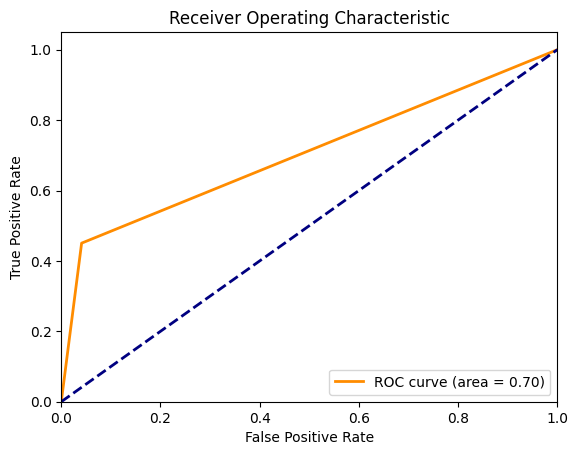

In [55]:
accuracy = accuracy_score(WAy_test, predict4)
precision = precision_score(WAy_test, predict4)
recall = recall_score(WAy_test, predict4)
fonescore = f1_score(WAy_test, predict4)
roc_auc = roc_auc_score(WAy_test, predict4)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(WAy_test, predict4)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# **Parámetros KNN - Notas**

# **Métricas KNN - Notas**

In [ ]:
accuracy = accuracy_score(WAy_test, predict4)
precision = precision_score(WAy_test, predict4)
recall = recall_score(WAy_test, predict4)
fonescore = f1_score(WAy_test, predict4)
roc_auc = roc_auc_score(WAy_test, predict4)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(WAy_test, predict4)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **Parámetros KNN - Escogido**

In [84]:
distance_classifier_1 = KNearestNeighbors(ESX_train, ESy_train.to_numpy(), n_neighbors=7, weights='distance')
distance_classifier_2 = KNearestNeighbors(ESX_train, ESy_train.to_numpy(), n_neighbors=9, weights='distance')
distance_classifier_3 = KNearestNeighbors(ESX_train, ESy_train.to_numpy(), n_neighbors=11, weights='distance')

predict1 = distance_classifier_1.predict(ESX_test)
print(accuracy_score(ESy_test.to_numpy(), predict1))
predict2 = distance_classifier_2.predict(ESX_test)
print(accuracy_score(ESy_test.to_numpy(), predict2))
predict3 = distance_classifier_3.predict(ESX_test)
print(accuracy_score(ESy_test.to_numpy(), predict3))

1.0
1.0
1.0


# **Métricas KNN - Escogido**

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


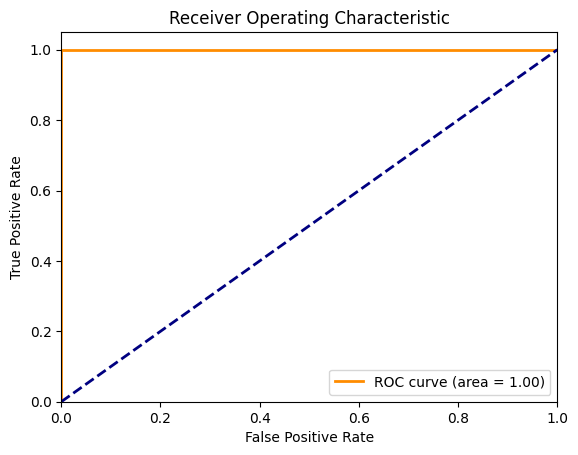

In [85]:
accuracy = accuracy_score(ESy_test, predict3)
precision = precision_score(ESy_test, predict3)
recall = recall_score(ESy_test, predict3)
fonescore = f1_score(ESy_test, predict3)
roc_auc = roc_auc_score(ESy_test, predict3)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(ESy_test, predict3)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **Parámetros Logit - WeatherAUS**

In [71]:
model = OurLogisticRegression(lr=0.05, num_iter=35000)
model.fit(WAX_train, WAy_train)
probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)
print(accuracy_score(WAy_test, y_pred))

model = OurLogisticRegression(lr=0.15, num_iter=35000)
model.fit(WAX_train, WAy_train)
probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)
print(accuracy_score(WAy_test, y_pred))

model = OurLogisticRegression(lr=0.25, num_iter=35000)
model.fit(WAX_train, WAy_train)
probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)
print(accuracy_score(WAy_test, y_pred))

model = OurLogisticRegression(lr=0.35, num_iter=35000)
model.fit(WAX_train, WAy_train)
probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)
print(accuracy_score(WAy_test, y_pred))

model = OurLogisticRegression(lr=0.35, num_iter=75000)
model.fit(WAX_train, WAy_train)
probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)
print(accuracy_score(WAy_test, y_pred))


0.8341225561442168
0.8351540156594308
0.8355759763702002
0.8354822073233625
0.8355759763702002


In [72]:
model = OurLogisticRegression(lr=0.25, num_iter=35000)
model.fit(WAX_train, WAy_train)
probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)
print(accuracy_score(WAy_test, y_pred))

0.8355759763702002


# **Métricas Logit - WeatherAUS**

Accuracy: 0.8355759763702002
Precision: 0.6981008513425017
Recall: 0.4519821920712317
F1 Score: 0.5487067301505597
ROC AUC: 0.6982400726790062


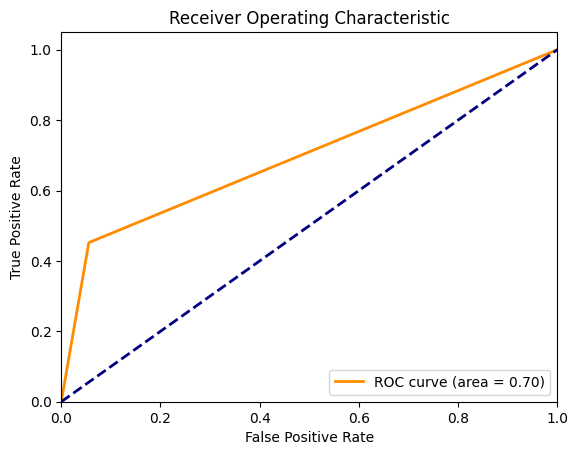

In [73]:
# mejores hiperparámetros encontrados
warnings.filterwarnings("ignore", category=RuntimeWarning)

probs = model.predict_prob(WAX_test)
y_pred = model.predict(WAX_test, threshold=0.5)

accuracy = accuracy_score(WAy_test, y_pred)
precision = precision_score(WAy_test, y_pred)
recall = recall_score(WAy_test, y_pred)
fonescore = f1_score(WAy_test, y_pred)
roc_auc = roc_auc_score(WAy_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(WAy_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **Parámetros Logit - Notas**

# **Métricas Logit - Notas**

# **Parámetros Logit - Escogido**

In [ ]:
model = OurLogisticRegression()

# fit the model to the training data
model.fit(ESX_train, ESy_train)

# Creamos un modelo de regresión logística
#model = LogisticRegression()

#model.fit(X_train, y_train)

warnings.filterwarnings("ignore", category=RuntimeWarning)

# PUNTO 2
# GRID SEARCH 
# Definimos la cuadrícula de hiperparámetros que queremos probar
param_grid = {
    'lr': [0.01, 0.1, 1],
    'num_iter': [1000, 2000, 3000, 5000],
    'fit_intercept': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=True))

# búsqueda de hiperparámetros en el conjunto de entrenamiento
grid_search.fit(ESX_train, ESy_train)


In [75]:
model = OurLogisticRegression(lr=0.05, num_iter=35000)
model.fit(ESX_train, ESy_train)
probs = model.predict_prob(ESX_test)
y_pred = model.predict(ESX_test, threshold=0.5)
print(accuracy_score(ESy_test, y_pred))

model = OurLogisticRegression(lr=0.15, num_iter=35000)
model.fit(ESX_train, ESy_train)
probs = model.predict_prob(ESX_test)
y_pred = model.predict(ESX_test, threshold=0.5)
print(accuracy_score(ESy_test, y_pred))

model = OurLogisticRegression(lr=0.25, num_iter=35000)
model.fit(ESX_train, ESy_train)
probs = model.predict_prob(ESX_test)
y_pred = model.predict(ESX_test, threshold=0.5)
print(accuracy_score(ESy_test, y_pred))

model = OurLogisticRegression(lr=0.35, num_iter=35000)
model.fit(ESX_train, ESy_train)
probs = model.predict_prob(ESX_test)
y_pred = model.predict(ESX_test, threshold=0.5)
print(accuracy_score(ESy_test, y_pred))

model = OurLogisticRegression(lr=0.35, num_iter=75000)
model.fit(ESX_train, ESy_train)
probs = model.predict_prob(ESX_test)
y_pred = model.predict(ESX_test, threshold=0.5)
print(accuracy_score(ESy_test, y_pred))

1.0
1.0
1.0
1.0
1.0


In [76]:
model = OurLogisticRegression(lr=0.35, num_iter=35000)
model.fit(ESX_train, ESy_train)
probs = model.predict_prob(ESX_test)
y_pred = model.predict(ESX_test, threshold=0.5)
print(accuracy_score(ESy_test, y_pred))


1.0


# **Métricas Logit - Escogido**

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


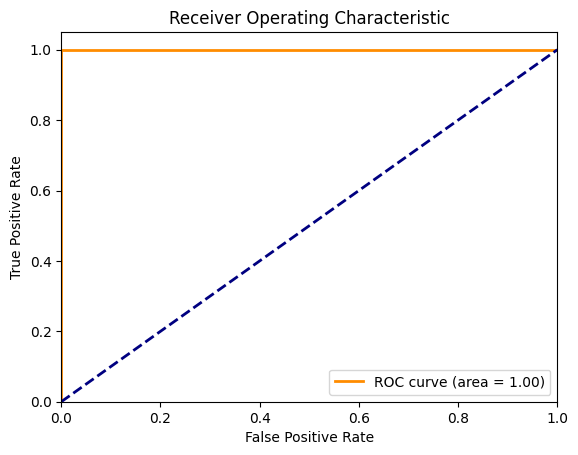

In [78]:
# mejores hiperparámetros encontrados
#warnings.filterwarnings("ignore", category=RuntimeWarning)

#best_params = grid_search.best_params_
#print("Mejores hiperparámetros encontrados:")
#print(best_params)

# mejor modelo entrenado
#best_model = grid_search.best_estimator_

# mejores hiperparámetros encontrados
warnings.filterwarnings("ignore", category=RuntimeWarning)

probs = model.predict_prob(WAX_test)
y_pred = model.predict(ESX_test, threshold=0.5)

accuracy = accuracy_score(ESy_test, y_pred)
precision = precision_score(ESy_test, y_pred)
recall = recall_score(ESy_test, y_pred)
fonescore = f1_score(ESy_test, y_pred)
roc_auc = roc_auc_score(ESy_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(ESy_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **Parámetros Árbol - WeatherAUS**

In [94]:
# Busqueda de parámetros
tree = Node(max_depth=250)
tree.fit(WAX_train, WAy_train)
y_pred = [tree.predict(x) for x in WAX_test]
accuracy = accuracy_score(WAy_test, y_pred)
print(accuracy)

tree = Node(max_depth=500)
tree.fit(WAX_train, WAy_train)
y_pred = [tree.predict(x) for x in WAX_test]
accuracy = accuracy_score(WAy_test, y_pred)
print(accuracy)

tree = Node(max_depth=750)
tree.fit(WAX_train, WAy_train)
y_pred = [tree.predict(x) for x in WAX_test]
accuracy = accuracy_score(WAy_test, y_pred)
print(accuracy)

tree = Node(max_depth=1000)
tree.fit(WAX_train, WAy_train)
y_pred = [tree.predict(x) for x in WAX_test]
accuracy = accuracy_score(WAy_test, y_pred)
print(accuracy)


0.7873786862956538
0.7873786862956538
0.7873786862956538


KeyboardInterrupt: 

# **Métricas Árbol - WeatherAUS**

In [ ]:
accuracy = accuracy_score(WAy_test, y_pred)
precision = precision_score(WAy_test, y_pred)
recall = recall_score(WAy_test, y_pred)
fonescore = f1_score(WAy_test, y_pred)
roc_auc = roc_auc_score(WAy_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(WAy_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **Parámetros Árbol - Notas**

In [97]:
# Busqueda de parámetros
tree = Node(max_depth=250)
tree.fit(NOX_train, NOy_train)
y_pred = [tree.predict(x) for x in NOX_test]
accuracy = accuracy_score(NOy_test, y_pred)
print(accuracy)

tree = Node(max_depth=500)
tree.fit(NOX_train, NOy_train)
y_pred = [tree.predict(x) for x in NOX_test]
accuracy = accuracy_score(NOy_test, y_pred)
print(accuracy)

tree = Node(max_depth=750)
tree.fit(NOX_train, NOy_train)
y_pred = [tree.predict(x) for x in NOX_test]
accuracy = accuracy_score(NOy_test, y_pred)
print(accuracy)

tree = Node(max_depth=1000)
tree.fit(NOX_train, NOy_train)
y_pred = [tree.predict(x) for x in NOX_test]
accuracy = accuracy_score(NOy_test, y_pred)
print(accuracy)

0.8181818181818182
0.8181818181818182
0.8181818181818182
0.8181818181818182


# **Métricas Árbol - Notas**

In [ ]:
accuracy = accuracy_score(NOy_test, y_pred)
precision = precision_score(NOy_test, y_pred)
recall = recall_score(NOy_test, y_pred)
fonescore = f1_score(NOy_test, y_pred)
roc_auc = roc_auc_score(NOy_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(NOy_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# **Parámetros Árbol - Escogido**

In [ ]:
# Busqueda de parámetros
tree = Node(max_depth=250)
tree.fit(ESX_train, ESy_train)
y_pred = [tree.predict(x) for x in ESX_test]
accuracy = accuracy_score(ESy_test, y_pred)
print(accuracy)

tree = Node(max_depth=500)
tree.fit(ESX_train, ESy_train)
y_pred = [tree.predict(x) for x in ESX_test]
accuracy = accuracy_score(ESy_test, y_pred)
print(accuracy)

tree = Node(max_depth=750)
tree.fit(ESX_train, ESy_train)
y_pred = [tree.predict(x) for x in ESX_test]
accuracy = accuracy_score(ESy_test, y_pred)
print(accuracy)

tree = Node(max_depth=1000)
tree.fit(ESX_train, ESy_train)
y_pred = [tree.predict(x) for x in ESX_test]
accuracy = accuracy_score(ESy_test, y_pred)
print(accuracy)

# **Métricas Árbol - Escogido**

In [ ]:
accuracy = accuracy_score(ESy_test, y_pred)
precision = precision_score(ESy_test, y_pred)
recall = recall_score(ESy_test, y_pred)
fonescore = f1_score(ESy_test, y_pred)
roc_auc = roc_auc_score(ESy_test, y_pred)

print("Accuracy: "+str(accuracy))
print("Precision: "+str(precision))
print("Recall: "+str(recall))
print("F1 Score: "+str(fonescore))
print("ROC AUC: "+str(roc_auc))

fpr, tpr, thresholds = roc_curve(ESy_test, y_pred)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()